In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import networkx as nx

/Users/florentinafabregas/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Communication graphs

In [2]:
dim_df = pd.read_csv("data/reddit_messages_dimensions.csv", sep="|")
dim_df.head(2)

,author,time,dest_author,author_state_code,dest_state_code,support_binary_adaptive_0.5,knowledge_binary_adaptive_0.5,conflict_binary_adaptive_0.5,power_binary_adaptive_0.5,similarity_binary_adaptive_0.5,...,support_binary_adaptive_0.99,knowledge_binary_adaptive_0.99,conflict_binary_adaptive_0.99,power_binary_adaptive_0.99,similarity_binary_adaptive_0.99,fun_binary_adaptive_0.99,status_binary_adaptive_0.99,trust_binary_adaptive_0.99,identity_binary_adaptive_0.99,romance_binary_adaptive_0.99
0,allurex,1.352921e+09,allurex,MO,MO,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dtrmp4,1.352929e+09,allurex,MI,MO,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Calculate distance in km

In [3]:
states = pd.read_csv('data/states.csv')
states.head()

state_centroids = (
    states.set_index("state")[["latitude", "longitude"]]
    .apply(tuple, axis=1)
    .to_dict()
)

In [4]:

def haversine(lat1, lon1, lat2, lon2):
    R = 6371 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [5]:
coords = states.set_index("state")[["latitude", "longitude"]]

dim_df = dim_df.merge(coords, left_on="author_state_code", right_index=True)
dim_df = dim_df.merge(coords, left_on="dest_state_code", right_index=True, suffixes=("_a", "_b"))

dim_df["distance_km"] = haversine(
    dim_df["latitude_a"], dim_df["longitude_a"],
    dim_df["latitude_b"], dim_df["longitude_b"]
)

dim_df.head(2)

,author,time,dest_author,author_state_code,dest_state_code,support_binary_adaptive_0.5,knowledge_binary_adaptive_0.5,conflict_binary_adaptive_0.5,power_binary_adaptive_0.5,similarity_binary_adaptive_0.5,...,fun_binary_adaptive_0.99,status_binary_adaptive_0.99,trust_binary_adaptive_0.99,identity_binary_adaptive_0.99,romance_binary_adaptive_0.99,latitude_a,longitude_a,latitude_b,longitude_b,distance_km
0,allurex,1.352921e+09,allurex,MO,MO,0,1,0,0,0,...,0,0,0,0,0,37.964253,-91.831833,37.964253,-91.831833,0.000000
1,dtrmp4,1.352929e+09,allurex,MI,MO,1,0,0,1,1,...,0,0,0,0,0,44.314844,-85.602364,37.964253,-91.831833,877.357917


In [9]:
# Check consistency for authors
author_state_consistency = (
    dim_df.groupby("author")["author_state_code"]
    .nunique()
    .reset_index(name="n_unique_states")
)

multi_state_authors = author_state_consistency[author_state_consistency["n_unique_states"] > 1]
print(f"Number of authors with >1 state: {len(multi_state_authors)}")

dest_state_consistency = (
    dim_df.groupby("dest_author")["dest_state_code"]
    .nunique()
    .reset_index(name="n_unique_states")
)

multi_state_dest_authors = dest_state_consistency[dest_state_consistency["n_unique_states"] > 1]
print(f"Number of dest_authors with >1 state: {len(multi_state_dest_authors)}")

Number of authors with >1 state: 0
Number of dest_authors with >1 state: 0


#### Full G with threshold >=4

In [6]:
edge_weights = (
    dim_df.groupby(["author", "dest_author"])
    .size()
    .reset_index(name="weight")
)

# Threshold of 4 
edge_weights = edge_weights[edge_weights["weight"] >= 4]

In [7]:
# Add distance_km as attribute

pair_distances = (
    dim_df.groupby(["author", "dest_author"])["distance_km"]
    .median()
    .reset_index()
)

edges = edge_weights.merge(pair_distances, on=["author", "dest_author"])

In [8]:
# Directed graph 

G = nx.DiGraph()

# nodes
author_states = (
    dim_df[["author", "author_state_code"]]
    .drop_duplicates()
    .set_index("author")["author_state_code"]
    .to_dict()
)
dest_states = (
    dim_df[["dest_author", "dest_state_code"]]
    .drop_duplicates()
    .set_index("dest_author")["dest_state_code"]
    .to_dict()
)
all_nodes = set(author_states.keys()) | set(dest_states.keys())
for node in all_nodes:
    state_code = author_states.get(node) or dest_states.get(node)
    G.add_node(node, state_code=state_code)

# EDGES
for _, row in edges.iterrows():
    G.add_edge(row["author"], row["dest_author"], weight=row["weight"],distance_km=row["distance_km"])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 632011 nodes and 277204 edges


### Dimension specific graphs

In [9]:
dimensions_interest = ['knowledge', 'support']

graphs = {}

for dim in dimensions_interest:
    col = f"{dim}_binary_adaptive_0.99" 
    df = dim_df[dim_df[col] == 1]

    edges = (
        df.groupby(["author", "dest_author"])
        .size()
        .reset_index(name="weight")
    )

    pair_distances = (
        df.groupby(["author", "dest_author"])["distance_km"]
        .median()
        .reset_index()
    )
    edges = edges.merge(pair_distances, on=["author", "dest_author"])

    Gd = nx.DiGraph()
    for _, row in edges.iterrows():
        Gd.add_edge(
            row["author"], 
            row["dest_author"], 
            weight=row["weight"], 
            distance_km=row["distance_km"]
        )

    graphs[dim] = Gd


In [15]:
dimensions_interest = ['knowledge', 'support']
graphs = {}

for dim in dimensions_interest:
    col = f"{dim}_binary_adaptive_0.99"
    df = dim_df[dim_df[col] == 1]

    edges = (
        df.groupby(["author", "dest_author"])
        .size()
        .reset_index(name="weight")
    )

    pair_distances = (
        df.groupby(["author", "dest_author"])["distance_km"]
        .median()
        .reset_index()
    )

    edges = edges.merge(pair_distances, on=["author", "dest_author"])

    Gd = nx.DiGraph()

    author_states = (
        df[["author", "author_state_code"]]
        .drop_duplicates()
        .set_index("author")["author_state_code"]
        .to_dict()
    )
    dest_author_states = (
        df[["dest_author", "dest_state_code"]]
        .drop_duplicates()
        .set_index("dest_author")["dest_state_code"]
        .to_dict()
    )
    all_nodes = set(author_states.keys()) | set(dest_author_states.keys())
    for node in all_nodes:
        state_code = author_states.get(node) or dest_author_states.get(node)
        Gd.add_node(node, state_code=state_code)

    for _, row in edges.iterrows():
        Gd.add_edge(
            row["author"],
            row["dest_author"],
            weight=row["weight"],
            distance_km=row["distance_km"]
        )

    graphs[dim] = Gd


In [10]:
print(f"SupportG has {graphs['support'].number_of_nodes()} nodes and {graphs['support'].number_of_edges()} edges")
print(f"KnowledgeG has {graphs['knowledge'].number_of_nodes()} nodes and {graphs['knowledge'].number_of_edges()} edges")

SupportG has 135321 nodes and 156300 edges
KnowledgeG has 126138 nodes and 155405 edges


In [16]:
print(f"SupportG has {graphs['support'].number_of_nodes()} nodes and {graphs['support'].number_of_edges()} edges")
print(f"KnowledgeG has {graphs['knowledge'].number_of_nodes()} nodes and {graphs['knowledge'].number_of_edges()} edges")

SupportG has 135321 nodes and 156300 edges
KnowledgeG has 126138 nodes and 155405 edges


## Left side figure 1

### A method: manually check social ties with support/knowledge messages

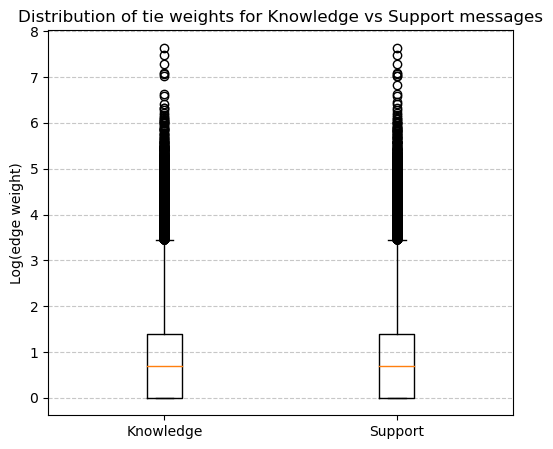

In [ ]:
tie_df_undir = (
    dim_df.assign(user1=lambda x: x[['author','dest_author']].min(axis=1),
                  user2=lambda x: x[['author','dest_author']].max(axis=1))
          .groupby(['user1','user2'])
          .agg({
              'support_binary_adaptive_0.99': 'sum',
              'knowledge_binary_adaptive_0.99': 'sum'
          })
          .reset_index()
)
tie_df_undir['weight'] = (
    dim_df.assign(user1=lambda x: x[['author','dest_author']].min(axis=1),
                  user2=lambda x: x[['author','dest_author']].max(axis=1))
          .groupby(['user1','user2'])
          .size()
          .values
)

support_ties_undir = tie_df_undir[tie_df_undir['support_binary_adaptive_0.99'] > 0]['weight']
knowledge_ties_undir = tie_df_undir[tie_df_undir['knowledge_binary_adaptive_0.99'] > 0]['weight']

knowledge_ties_log = np.log(knowledge_ties_undir)
support_ties_log = np.log(support_ties_undir)

plt.figure(figsize=(6, 5))
plt.boxplot(
    [knowledge_ties_log, support_ties_log],
    labels=['Knowledge', 'Support'],
)
plt.ylabel('Log(edge weight)')
plt.title('Distribution of tie weights for Knowledge vs Support messages')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## ok!

## Right side figure 1

### Compute the bins

In [ ]:
# Social ties full dataset 

# Create canonical pair order (sorted tuples)
dim_df["pair"] = dim_df.apply(
    lambda x: tuple(sorted([x["author"], x["dest_author"]])),
    axis=1
)

# Drop duplicates so each pair appears only once
unique_pairs = dim_df.drop_duplicates(subset="pair")
bins = unique_pairs["distance_km"].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
print("Bins based on unique undirected author pairs:", bins)

time >> 6min

### Compute bins by filtering states

In [11]:
states_to_remove = ['DC', 'AK', 'MS', 'WV', 'SD', 'WY', 'ND']

filtered_df = dim_df[
    (~dim_df["author_state_code"].isin(states_to_remove)) &
    (~dim_df["dest_state_code"].isin(states_to_remove))
].copy()

filtered_df["pair"] = filtered_df.apply(
    lambda x: tuple(sorted([x["author"], x["dest_author"]])),
    axis=1
)

unique_pairs = filtered_df.drop_duplicates(subset="pair")
bins = unique_pairs["distance_km"].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values

print("Bins based on unique undirected author pairs:", bins)


Bins based on unique undirected author pairs: [   0.            0.         1054.27004372 1796.68872651 2715.43596665
 8163.84245135]


## Last method: work with full graph and undirected

In [12]:
edge_weights = (
    dim_df.groupby(["author", "dest_author"])
    .agg(
        weight=("author", "size"),  
        support_weight=("support_binary_adaptive_0.99", "sum"), 
        knowledge_weight=("knowledge_binary_adaptive_0.99", "sum"),  
    )
    .reset_index()
)

G = nx.from_pandas_edgelist(
    edge_weights,
    source="author",
    target="dest_author",
    edge_attr=["weight", "support_weight", "knowledge_weight"],
    create_using=nx.DiGraph()  
)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 632011 nodes and 12801689 edges


#### Full graph to dataframe

In [13]:
def graph_to_dataframe(G):
    edges_data = [
        {
            "author": u,
            "dest_author": v,
            **attrs
        }
        for u, v, attrs in G.edges(data=True)
    ]
    df = pd.DataFrame(edges_data)
    return df

full_edges_df = graph_to_dataframe(G)

In [14]:
full_edges_df.head(3)

,author,dest_author,weight,support_weight,knowledge_weight
0,-------------------7,lyle_the_crocodile,1,0,0
1,-------------------7,ramsrule99,1,0,0
2,-------------------7,rj22497,1,0,0


### Add distance

In [15]:
users_df = (
    dim_df[["author", "author_state_code"]]
    .drop_duplicates()
    .rename(columns={"author_state_code": "state"})
)
len(users_df)

598992

In [22]:
# With dest authors
authors_df = dim_df[['author', 'author_state_code']].rename(columns={'author': 'author', 'author_state_code': 'state'})
dest_df = dim_df[['dest_author', 'dest_state_code']].rename(columns={'dest_author': 'author', 'dest_state_code': 'state'})

users_df = pd.concat([authors_df, dest_df], ignore_index=True).drop_duplicates(subset='author')
len(users_df)


632011

In [23]:
states = pd.read_csv('data/states.csv')
states.head()

state_centroids = (
    states.set_index("state")[["latitude", "longitude"]]
    .apply(tuple, axis=1)
    .to_dict()
)
coords = states.set_index("state")[["latitude", "longitude"]]

# Distance lookup table
import itertools

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

state_pairs = list(itertools.product(coords.index, coords.index))
distances = {}

for s1, s2 in state_pairs:
    lat1, lon1 = coords.loc[s1]
    lat2, lon2 = coords.loc[s2]
    distances[(s1, s2)] = haversine_np(lat1, lon1, lat2, lon2)

dist_series = pd.Series(distances)

In [24]:
# Add state to edge_df

def add_distance(edges_df):

    edges = (
        edges_df
        .merge(users_df, on="author", how="left")
        .rename(columns={"state": "author_state"})
        .merge(users_df, left_on="dest_author", right_on="author", how="left")
        .rename(columns={"state": "dest_state"})
        .drop(columns=["author_y"])
        .rename(columns={"author_x": "author"})
    )

    edges["distance_km"] = edges.apply(
        lambda row: dist_series.get((row["author_state"], row["dest_state"]), np.nan),
        axis=1
    )
    return edges

In [25]:
full_edges_distance = add_distance(full_edges_df)
print(len(full_edges_distance))

12801689


In [26]:
bins = full_edges_distance['distance_km'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
print("Bins quintiles:", bins)

Bins quintiles: [   0.            0.         1049.1247125  1800.98655954 2762.7408041
 8163.84245135]


### Make indirected

In [27]:
def make_undirected_edges(edges_df):
    edges = edges_df.copy()
    edges["node_min"] = edges[["author", "dest_author"]].min(axis=1)
    edges["node_max"] = edges[["author", "dest_author"]].max(axis=1)
    
    agg_cols = ["weight", "support_weight", "knowledge_weight"]
    edges_undirected = (
        edges.groupby(["node_min", "node_max"], as_index=False)[agg_cols].sum()
    ) 

    if "distance_km" in edges.columns:
        edges_undirected = (
            edges_undirected.merge(
                edges[["node_min", "node_max", "distance_km"]].drop_duplicates(),
                on=["node_min", "node_max"],
                how="left"
            )
        )

    edges_undirected = edges_undirected.rename(columns={
        "node_min": "author",
        "node_max": "dest_author"
    })
    return edges_undirected


In [28]:
full_undirected = make_undirected_edges(full_edges_distance)
len(full_undirected)

10517572

In [29]:
bins = full_undirected['distance_km'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
print("Bins quintiles:", bins)

Bins quintiles: [   0.           88.8327645  1059.01358728 1807.74910087 2762.7408041
 8163.84245135]


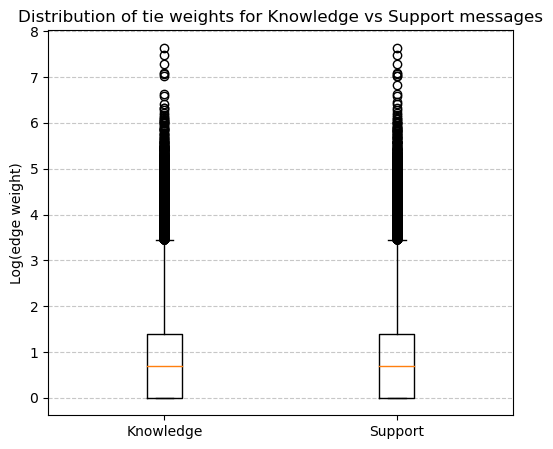

In [30]:
knowledge_ties = full_undirected[full_undirected['knowledge_weight'] >0]['weight']
support_ties = full_undirected[full_undirected['support_weight'] >0]['weight']

knowledge_ties_log = np.log(knowledge_ties)
support_ties_log = np.log(support_ties)

plt.figure(figsize=(6, 5))
plt.boxplot(
    [knowledge_ties_log, support_ties_log],
    labels=['Knowledge', 'Support'],
    #showfliers=False,  # optional: hide outliers for clarity
)
#plt.yscale('log')
plt.ylabel('Log(edge weight)')
plt.title('Distribution of tie weights for Knowledge vs Support messages')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Matching the format

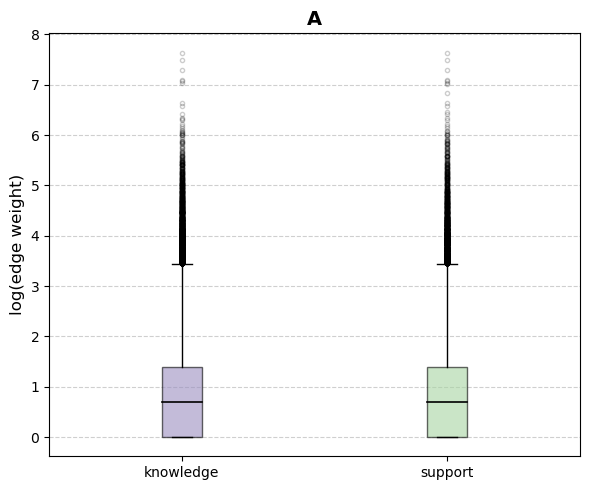

In [ ]:
knowledge_ties = full_undirected[full_undirected['knowledge_weight'] > 0]['weight']
support_ties = full_undirected[full_undirected['support_weight'] > 0]['weight']

knowledge_ties_log = np.log(knowledge_ties)
support_ties_log = np.log(support_ties)

# Create the plot
plt.figure(figsize=(6, 5))
box = plt.boxplot(
    [knowledge_ties_log, support_ties_log],
    labels=['knowledge', 'support'],
    patch_artist=True,  # enables colored boxes
    medianprops=dict(color='black', linewidth=1.2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markersize=3, alpha=0.2, color='gray')
)

# Apply custom colors
colors = ['#9B8EC1', '#A8D5A2'] 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.ylabel('log(edge weight)', fontsize=12)
plt.title('A', fontsize=14, fontweight='bold', loc='center')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Right  side

#### Assign bins

In [31]:
full_undirected['distance_bin'] = pd.cut(
    full_undirected['distance_km'],
    bins=bins,
    include_lowest=True
)


bin_medians = full_undirected.groupby('distance_bin')['distance_km'].median()
full_undirected['distance_bin_label'] = full_undirected['distance_bin'].map(bin_medians)

unique_medians = full_undirected["distance_bin_label"].dropna().unique()
print(np.sort(unique_medians))

/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_908/1939076309.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_medians = full_undirected.groupby('distance_bin')['distance_km'].median()


[   0.          728.62322405 1383.01612136 2263.17547235 3619.67276339]


#### True $p(d|l)$

In [32]:
full_undirected['support_binary'] = (full_undirected['support_weight'] >0).astype('int')
full_undirected['knowledge_binary'] = (full_undirected['knowledge_weight'] >0).astype('int')

In [33]:
def compute_p_l(df):

    total_ties = df.groupby('distance_bin_label').size()
    support_ties = df.groupby('distance_bin_label')["support_binary"].sum()
    knowledge_ties = df.groupby('distance_bin_label')["knowledge_binary"].sum()

    p_support_relation = (support_ties / total_ties).fillna(0)
    p_knowledge_relation = (knowledge_ties / total_ties).fillna(0)

    # With weights
    total_weight = df.groupby('distance_bin_label')["weight"].sum()
    support_weight = df.groupby('distance_bin_label')["support_weight"].sum()
    knowledge_weight = df.groupby('distance_bin_label')["knowledge_weight"].sum()

    p_support_message = (support_weight / total_weight).fillna(0)
    p_knowledge_message = (knowledge_weight / total_weight).fillna(0)

    result = pd.DataFrame({
        "p_support_relation": p_support_relation,
        "p_support_message": p_support_message,
        "p_knowledge_relation": p_knowledge_relation,
        "p_knowledge_message": p_knowledge_message
    })

    return result

In [ ]:
true_p = compute_p_l(full_undirected)

In [35]:
true_p

,p_support_relation,p_support_message,p_knowledge_relation,p_knowledge_message
distance_bin_label,,,,
0.000000,0.019060,0.011128,0.017289,0.010673
728.623224,0.013024,0.009612,0.013433,0.009444
1383.016121,0.013034,0.009733,0.013710,0.009718
2263.175472,0.013064,0.009743,0.014023,0.009974
3619.672763,0.012929,0.009660,0.014382,0.010250


#### Null model

In [70]:
def compute_null_p(full_df, n_iter=2, bin_col="distance_bin", random_state=None):
    
    rng = np.random.default_rng(random_state)
    results = []
    state_list = users_df["state"].values

    for i in range(n_iter):
        shuffled_users = users_df[["author", "state"]].copy()
        shuffled_users["state"] = rng.permutation(state_list)

        # --- Merge shuffled states back into edges ---
        shuffled_edges = (
            full_df
            .merge(
                shuffled_users.rename(columns={"state": "author_state"}),
                on="author",
                how="left"
            )
            .merge(
                shuffled_users.rename(columns={"author": "dest_author", "state": "dest_author_state"}),
                on="dest_author",
                how="left"
            )
        )

        # Vectorized lookup - MUCH faster
        shuffled_edges["distance_km"] = [
            dist_series.get((a, d), np.nan) 
            for a, d in zip(shuffled_edges["author_state"], shuffled_edges["dest_author_state"])
        ]

        shuffled_edges[bin_col] = pd.cut(
            shuffled_edges["distance_km"], bins=bins, include_lowest=True
        )

        p_df = compute_p_l(shuffled_edges)
        p_df["iteration"] = i
        results.append(p_df)

    all_results = pd.concat(results, ignore_index=False)

    summary = all_results.groupby(all_results.index).agg(["mean", "std"])
    ci = 1.96 * summary.xs("std", axis=1, level=1) / np.sqrt(n_iter)
    mean = summary.xs("mean", axis=1, level=1)

    summary_df = mean.copy()
    for col in mean.columns:
        summary_df[f"{col}_ci"] = ci[col]

    return summary_df

In [ ]:
null_p = compute_null_p(full_undirected)

#### More efficient...

In [36]:
users_df.head(1)

,author,state
0,allurex,MO


In [37]:
# Map authors to their states
author_state_map = users_df.set_index("author")["state"].to_dict()

full_undirected['author_state'] = full_undirected['author'].map(author_state_map)
full_undirected['dest_state'] = full_undirected['dest_author'].map(author_state_map)
full_undirected.head(1)


,author,dest_author,weight,support_weight,knowledge_weight,distance_km,distance_bin,distance_bin_label,support_binary,knowledge_binary,author_state,dest_state
0,-------------------7,lyle_the_crocodile,1,0,0,1596.476361,"(1059.014, 1807.749]",1383.016121,0,0,NY,MO


In [38]:
# List of all states
states_list = sorted(states['state'].unique())
state_to_code = {s: i for i, s in enumerate(states_list)}
n_states = len(states_list)

dist_matrix = np.zeros((n_states, n_states), dtype=float)

for (s1, s2), d in distances.items():
    i, j = state_to_code[s1], state_to_code[s2]
    dist_matrix[i, j] = d

In [39]:
dist_matrix.shape

(52, 52)

In [40]:
def compute_null_p_optimized(full_df, n_iter=50, bin_col="distance_bin", bins=bins, random_state=None):
   
    rng = np.random.default_rng(random_state)
    
    author_codes = full_df['author_state'].map(state_to_code).values.astype(int)
    dest_codes = full_df['dest_state'].map(state_to_code).values.astype(int)
    n_rows = len(full_df)
    
    results = []
    
    for i in range(n_iter):
        shuffled_author = rng.permutation(author_codes)
        shuffled_dest = rng.permutation(dest_codes)
        
        shuffled_distances = dist_matrix[shuffled_author, shuffled_dest]
        
        full_df['distance_bin_label'] = pd.cut(shuffled_distances, bins=bins, include_lowest=True)
        
        p_df = compute_p_l(full_df)
        p_df['iteration'] = i  
        results.append(p_df)
    
    all_results = pd.concat(results)
    
    summary = all_results.groupby(all_results.index).agg(['mean', 'std'])
    mean = summary.xs('mean', axis=1, level=1)
    ci = 1.96 * summary.xs('std', axis=1, level=1) / np.sqrt(n_iter)
    
    summary_df = mean.copy()
    for col in mean.columns:
        summary_df[f"{col}_ci"] = ci[col]
    
    return summary_df


In [ ]:
p_null = compute_null_p_optimized(full_undirected)

In [42]:
p_null

,p_support_relation,p_support_message,p_knowledge_relation,p_knowledge_message,iteration,p_support_relation_ci,p_support_message_ci,p_knowledge_relation_ci,p_knowledge_message_ci,iteration_ci
distance_bin_label,,,,,,,,,,
"(-0.001, 88.833]",0.014198,0.010027,0.014596,0.010056,24.5,0.000044,0.000035,0.000038,0.000038,4.040644
"(88.833, 1059.014]",0.014240,0.010042,0.014567,0.010056,24.5,0.000020,0.000016,0.000016,0.000020,4.040644
"(1059.014, 1807.749]",0.014226,0.010038,0.014562,0.010044,24.5,0.000019,0.000016,0.000019,0.000018,4.040644
"(1807.749, 2762.741]",0.014226,0.010035,0.014580,0.010048,24.5,0.000018,0.000014,0.000015,0.000012,4.040644
"(2762.741, 8163.842]",0.014211,0.010036,0.014550,0.010030,24.5,0.000020,0.000015,0.000018,0.000016,4.040644


In [43]:
true_p

,p_support_relation,p_support_message,p_knowledge_relation,p_knowledge_message
distance_bin_label,,,,
0.000000,0.019060,0.011128,0.017289,0.010673
728.623224,0.013024,0.009612,0.013433,0.009444
1383.016121,0.013034,0.009733,0.013710,0.009718
2263.175472,0.013064,0.009743,0.014023,0.009974
3619.672763,0.012929,0.009660,0.014382,0.010250


In [44]:
p_null_renamed = p_null.copy()
p_null_renamed.index = true_p.index

delta_p = pd.DataFrame(index=true_p.index)

prob_columns = ['p_support_relation', 'p_support_message', 'p_knowledge_relation', 'p_knowledge_message']

for col in prob_columns:
    delta_p[f'delta_{col}'] = (true_p[col] / p_null_renamed[col]) - 1
    delta_p[f'delta_{col}_ci'] = p_null_renamed[f'{col}_ci'] * abs(true_p[col] / (p_null_renamed[col] ** 2))

if 'distance_bin_label' in true_p.columns:
    delta_p['distance_bin_label'] = true_p['distance_bin_label']

# print("Delta p (% change compared to null model):")
# print(delta_p)

delta_p_percent = delta_p.copy()
for col in prob_columns:
    delta_p_percent[f'delta_{col}'] = delta_p_percent[f'delta_{col}'] * 100
    delta_p_percent[f'delta_{col}_ci'] = delta_p_percent[f'delta_{col}_ci'] * 100

print("\nDelta p as percentages:")
delta_p_percent


Delta p as percentages:


,delta_p_support_relation,delta_p_support_relation_ci,delta_p_support_message,delta_p_support_message_ci,delta_p_knowledge_relation,delta_p_knowledge_relation_ci,delta_p_knowledge_message,delta_p_knowledge_message_ci
distance_bin_label,,,,,,,,
0.000000,34.246728,0.418227,10.978166,0.386132,18.445129,0.309120,6.140984,0.397476
728.623224,-8.538732,0.127106,-4.278319,0.150094,-7.787137,0.103079,-6.086743,0.186057
1383.016121,-8.383126,0.121406,-3.040441,0.152015,-5.853159,0.121803,-3.244006,0.174403
2263.175472,-8.167525,0.114764,-2.913560,0.137459,-3.819471,0.098431,-0.735718,0.120608
3619.672763,-9.025828,0.125159,-3.745037,0.140283,-1.151529,0.119463,2.196374,0.164623


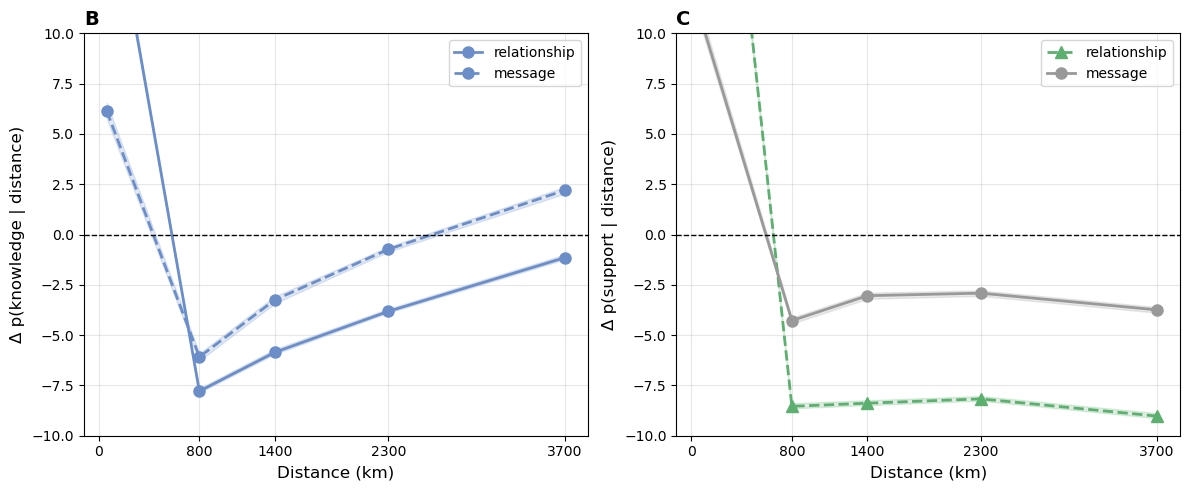

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_centers = [65, 800, 1400, 2300, 3700]

ax1.plot(bin_centers, delta_p_percent['delta_p_knowledge_relation'], 
         marker='o', linestyle='-', color='#6B8EC9', linewidth=2, markersize=8, label='relationship')
ax1.plot(bin_centers, delta_p_percent['delta_p_knowledge_message'], 
         marker='o', linestyle='--', color='#6B8EC9', linewidth=2, markersize=8, label='message')

ax1.fill_between(bin_centers, 
                  delta_p_percent['delta_p_knowledge_relation'] - delta_p_percent['delta_p_knowledge_relation_ci'],
                  delta_p_percent['delta_p_knowledge_relation'] + delta_p_percent['delta_p_knowledge_relation_ci'],
                  alpha=0.2, color='#6B8EC9')
ax1.fill_between(bin_centers, 
                  delta_p_percent['delta_p_knowledge_message'] - delta_p_percent['delta_p_knowledge_message_ci'],
                  delta_p_percent['delta_p_knowledge_message'] + delta_p_percent['delta_p_knowledge_message_ci'],
                  alpha=0.2, color='#6B8EC9')

ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Distance (km)', fontsize=12)
ax1.set_ylabel('Δ p(knowledge | distance)', fontsize=12)
ax1.set_title('B', fontsize=14, fontweight='bold', loc='left')
ax1.set_ylim(-10, 10)
ax1.set_xticks([0, 800, 1400, 2300, 3700])
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(bin_centers, delta_p_percent['delta_p_support_relation'], 
         marker='^', linestyle='--', color='#5CAF6E', linewidth=2, markersize=8, label='relationship')
ax2.plot(bin_centers, delta_p_percent['delta_p_support_message'], 
         marker='o', linestyle='-', color='#999999', linewidth=2, markersize=8, label='message')

ax2.fill_between(bin_centers, 
                  delta_p_percent['delta_p_support_relation'] - delta_p_percent['delta_p_support_relation_ci'],
                  delta_p_percent['delta_p_support_relation'] + delta_p_percent['delta_p_support_relation_ci'],
                  alpha=0.2, color='#5CAF6E')
ax2.fill_between(bin_centers, 
                  delta_p_percent['delta_p_support_message'] - delta_p_percent['delta_p_support_message_ci'],
                  delta_p_percent['delta_p_support_message'] + delta_p_percent['delta_p_support_message_ci'],
                  alpha=0.2, color='#999999')

ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Distance (km)', fontsize=12)
ax2.set_ylabel('Δ p(support | distance)', fontsize=12)
ax2.set_title('C', fontsize=14, fontweight='bold', loc='left')
ax2.set_ylim(-10, 10)
ax2.set_xticks([0, 800, 1400, 2300, 3700])
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [52]:
bin_labels = [str(int(round(x))) for x in sorted(unique_medians)]
bin_labels

['0', '729', '1383', '2263', '3620']

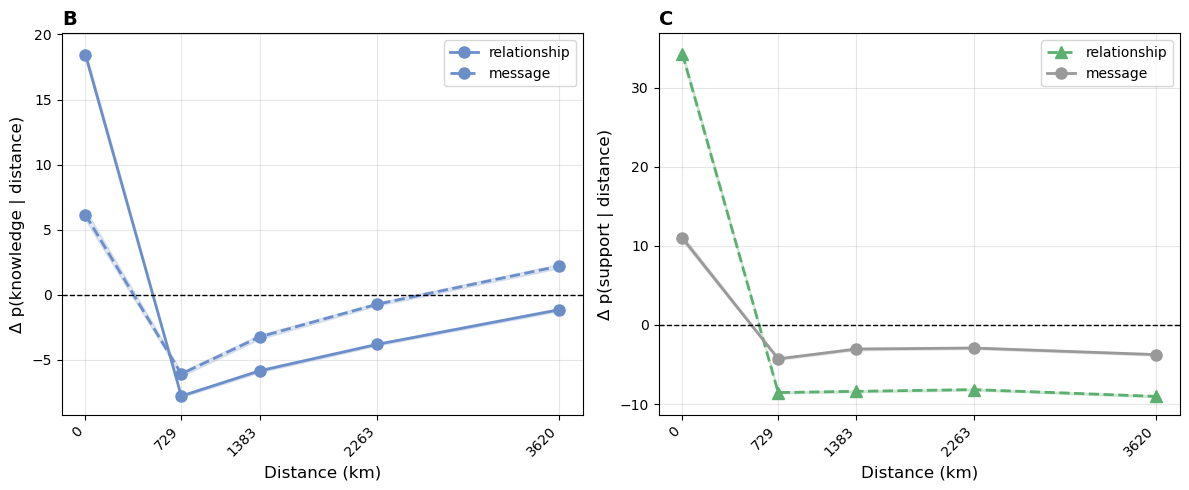

In [53]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_centers = [65, 800, 1400, 2300, 3700]

ax1.plot(bin_centers, delta_p_percent['delta_p_knowledge_relation'], 
         marker='o', linestyle='-', color='#6B8EC9', linewidth=2, markersize=8, label='relationship')
ax1.plot(bin_centers, delta_p_percent['delta_p_knowledge_message'], 
         marker='o', linestyle='--', color='#6B8EC9', linewidth=2, markersize=8, label='message')

ax1.fill_between(bin_centers, 
                  delta_p_percent['delta_p_knowledge_relation'] - delta_p_percent['delta_p_knowledge_relation_ci'],
                  delta_p_percent['delta_p_knowledge_relation'] + delta_p_percent['delta_p_knowledge_relation_ci'],
                  alpha=0.2, color='#6B8EC9')
ax1.fill_between(bin_centers, 
                  delta_p_percent['delta_p_knowledge_message'] - delta_p_percent['delta_p_knowledge_message_ci'],
                  delta_p_percent['delta_p_knowledge_message'] + delta_p_percent['delta_p_knowledge_message_ci'],
                  alpha=0.2, color='#6B8EC9')

ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Distance (km)', fontsize=12)
ax1.set_ylabel('Δ p(knowledge | distance)', fontsize=12)
ax1.set_title('B', fontsize=14, fontweight='bold', loc='left')
#ax1.set_ylim(-10, 10)
#ax1.set_xticks([0, 800, 1400, 2300, 3700])
ax1.set_xticks(bin_centers)
ax1.set_xticklabels(bin_labels, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(bin_centers, delta_p_percent['delta_p_support_relation'], 
         marker='^', linestyle='--', color='#5CAF6E', linewidth=2, markersize=8, label='relationship')
ax2.plot(bin_centers, delta_p_percent['delta_p_support_message'], 
         marker='o', linestyle='-', color='#999999', linewidth=2, markersize=8, label='message')

ax2.fill_between(bin_centers, 
                  delta_p_percent['delta_p_support_relation'] - delta_p_percent['delta_p_support_relation_ci'],
                  delta_p_percent['delta_p_support_relation'] + delta_p_percent['delta_p_support_relation_ci'],
                  alpha=0.2, color='#5CAF6E')
ax2.fill_between(bin_centers, 
                  delta_p_percent['delta_p_support_message'] - delta_p_percent['delta_p_support_message_ci'],
                  delta_p_percent['delta_p_support_message'] + delta_p_percent['delta_p_support_message_ci'],
                  alpha=0.2, color='#999999')

ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Distance (km)', fontsize=12)
ax2.set_ylabel('Δ p(support | distance)', fontsize=12)
ax2.set_title('C', fontsize=14, fontweight='bold', loc='left')
#ax2.set_ylim(-10, 10)
#ax2.set_xticks([0, 800, 1400, 2300, 3700])
ax2.set_xticks(bin_centers)
ax2.set_xticklabels(bin_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Final subplot joining both plots

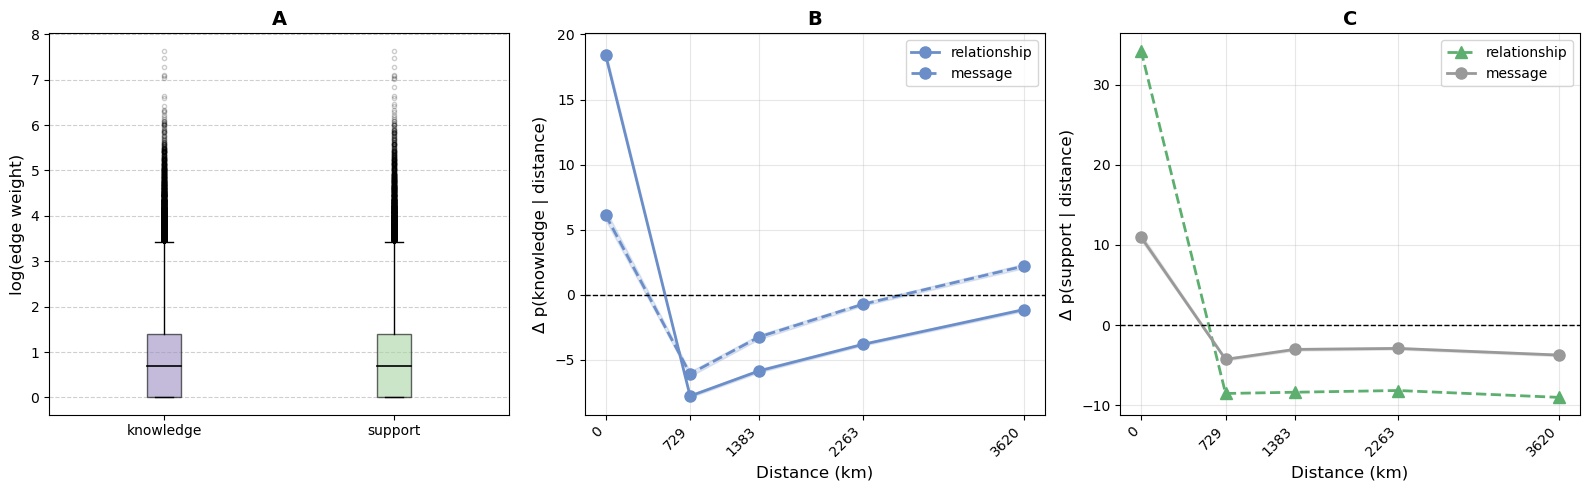

In [57]:

knowledge_ties = full_undirected[full_undirected['knowledge_weight'] > 0]['weight']
support_ties = full_undirected[full_undirected['support_weight'] > 0]['weight']

knowledge_ties_log = np.log(knowledge_ties)
support_ties_log = np.log(support_ties)


fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))

box = ax0.boxplot(
    [knowledge_ties_log, support_ties_log],
    labels=['knowledge', 'support'],
    patch_artist=True,
    medianprops=dict(color='black', linewidth=1.2),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', markersize=3, alpha=0.2, color='gray')
)

colors = ['#9B8EC1', '#A8D5A2']  # purple, green
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax0.set_ylabel('log(edge weight)', fontsize=12)
ax0.set_title('A', fontsize=14, fontweight='bold', loc='center')
ax0.grid(True, axis='y', linestyle='--', alpha=0.6)


ax1.plot(bin_centers, delta_p_percent['delta_p_knowledge_relation'],
         marker='o', linestyle='-', color='#6B8EC9', linewidth=2, markersize=8, label='relationship')
ax1.plot(bin_centers, delta_p_percent['delta_p_knowledge_message'],
         marker='o', linestyle='--', color='#6B8EC9', linewidth=2, markersize=8, label='message')

ax1.fill_between(bin_centers,
                 delta_p_percent['delta_p_knowledge_relation'] - delta_p_percent['delta_p_knowledge_relation_ci'],
                 delta_p_percent['delta_p_knowledge_relation'] + delta_p_percent['delta_p_knowledge_relation_ci'],
                 alpha=0.2, color='#6B8EC9')
ax1.fill_between(bin_centers,
                 delta_p_percent['delta_p_knowledge_message'] - delta_p_percent['delta_p_knowledge_message_ci'],
                 delta_p_percent['delta_p_knowledge_message'] + delta_p_percent['delta_p_knowledge_message_ci'],
                 alpha=0.2, color='#6B8EC9')

ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Distance (km)', fontsize=12)
ax1.set_ylabel('Δ p(knowledge | distance)', fontsize=12)
ax1.set_title('B', fontsize=14, fontweight='bold', loc='center')
ax1.set_xticks(bin_centers)
ax1.set_xticklabels(bin_labels, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.legend()


ax2.plot(bin_centers, delta_p_percent['delta_p_support_relation'],
         marker='^', linestyle='--', color='#5CAF6E', linewidth=2, markersize=8, label='relationship')
ax2.plot(bin_centers, delta_p_percent['delta_p_support_message'],
         marker='o', linestyle='-', color='#999999', linewidth=2, markersize=8, label='message')

ax2.fill_between(bin_centers,
                 delta_p_percent['delta_p_support_message'] - delta_p_percent['delta_p_support_message_ci'],
                 delta_p_percent['delta_p_support_message'] + delta_p_percent['delta_p_support_message_ci'],
                 alpha=0.2, color='#999999')

ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Distance (km)', fontsize=12)
ax2.set_ylabel('Δ p(support | distance)', fontsize=12)
ax2.set_title('C', fontsize=14, fontweight='bold', loc='center')
ax2.set_xticks(bin_centers)
ax2.set_xticklabels(bin_labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## From here previous method...

______________________

In [16]:
# Full communication graph G
def edges_to_df(G):
    return pd.DataFrame([
        (
            u,
            v,
            G.nodes[u].get("state_code"),
            G.nodes[v].get("state_code"),
            data.get("weight"),
            data.get("distance_km")
        )
        for u, v, data in G.edges(data=True)
    ], columns=["author", "dest_author", "author_state_code", "dest_state_code", "weight", "distance_km"])

full_edges_df = edges_to_df(G)
full_edges_df["distance_bin"] = pd.cut(full_edges_df["distance_km"], bins=bins, include_lowest=True)

bin_medians = full_edges_df.groupby("distance_bin")["distance_km"].median()
print(bin_medians)

full_edges_df["distance_bin_label"] = full_edges_df["distance_bin"].map(bin_medians)
full_edges_df.head(2)

distance_bin
(-0.001, 88.833]           0.000000
(88.833, 1059.014]       712.552577
(1059.014, 1807.749]    1374.476493
(1807.749, 2762.741]    2263.175472
(2762.741, 8163.842]    3619.672763
Name: distance_km, dtype: float64


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_65761/643895274.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_medians = full_edges_df.groupby("distance_bin")["distance_km"].median()


,author,dest_author,author_state_code,dest_state_code,weight,distance_km,distance_bin,distance_bin_label
0,scarywoody,beersyummy,OR,OH,5,3101.224625,"(2762.741, 8163.842]",3619.672763
1,scarywoody,livefreefrathard,OR,NM,4,1651.853313,"(1059.014, 1807.749]",1374.476493


In [21]:
len(full_edges_df)

277204

In [22]:
# Dimension-specific 

def dimension_edges_df(Gd, bins):
    df = edges_to_df(Gd)
    df["distance_bin"] = pd.cut(df["distance_km"], bins=bins, include_lowest=True)
    return df

support_edges_df = dimension_edges_df(graphs['support'], bins)
knowledge_edges_df = dimension_edges_df(graphs['knowledge'], bins)

In [23]:
len(support_edges_df)/len(full_edges_df)

0.5638446775659803

In [24]:
support_edges_df.head(2)

,author,dest_author,author_state_code,dest_state_code,weight,distance_km,distance_bin
0,bigalbertbake,1ronpur3,OH,FL,1,1423.735639,"(1059.014, 1807.749]"
1,cark_muban,jgrizz0011,TX,VA,1,2029.761793,"(1807.749, 2762.741]"


In [25]:
full_edges_df.head(2)

,author,dest_author,author_state_code,dest_state_code,weight,distance_km,distance_bin,distance_bin_label
0,kazinova,kazinova,OH,OH,4,0.0,"(-0.001, 88.833]",0.0
1,shvr,nathanbatson,NC,NC,4,0.0,"(-0.001, 88.833]",0.0


### Compute $p(d|l)$

In [26]:
def compute_p_dl(full_edges_df, dim_edges_df):
    total_per_bin = full_edges_df.groupby("distance_bin").size()
    dim_per_bin = dim_edges_df.groupby("distance_bin").size()

    p_dl = (dim_per_bin / total_per_bin)#.fillna(0)
    return p_dl

p_support = compute_p_dl(full_edges_df, support_edges_df)
p_knowledge = compute_p_dl(full_edges_df, knowledge_edges_df)

print("p(d|l) for support dimension:\n", p_support)
print("p(d|l) for knowledge dimension:\n", p_knowledge)


p(d|l) for support dimension:
 distance_bin
(-0.001, 88.833]        0.358718
(88.833, 1059.014]      0.693504
(1059.014, 1807.749]    0.707503
(1807.749, 2762.741]    0.715102
(2762.741, 8163.842]    0.725144
dtype: float64
p(d|l) for knowledge dimension:
 distance_bin
(-0.001, 88.833]        0.319488
(88.833, 1059.014]      0.689976
(1059.014, 1807.749]    0.718407
(1807.749, 2762.741]    0.743327
(2762.741, 8163.842]    0.781671
dtype: float64


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_57754/1146646729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_bin = full_edges_df.groupby("distance_bin").size()
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_57754/1146646729.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dim_per_bin = dim_edges_df.groupby("distance_bin").size()
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_57754/1146646729.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

### Null model

In [8]:
# Distance lookup table

import itertools

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

state_pairs = list(itertools.product(coords.index, coords.index))
distances = {}

for s1, s2 in state_pairs:
    lat1, lon1 = coords.loc[s1]
    lat2, lon2 = coords.loc[s2]
    distances[(s1, s2)] = haversine_np(lat1, lon1, lat2, lon2)

dist_series = pd.Series(distances)

In [28]:
def p_null(n_iter, edge_df, bins, full_edges_df):

    p_null = []
    for i in range(n_iter):

        shuffled = edge_df.copy()
        shuffled["author_state_code"] = np.random.permutation(shuffled["author_state_code"].values)
        shuffled["dest_state_code"] = np.random.permutation(shuffled["dest_state_code"].values)

        shuffled['distance_km'] = shuffled.apply(
            lambda x: dist_series.get((x['author_state_code'], x['dest_state_code']), np.nan),
            axis=1
        )

        shuffled['distance_bin'] = pd.cut(
            shuffled['distance_km'],
            bins=bins,
            include_lowest=True
        )
        
        p_null.append(compute_p_dl(full_edges_df, shuffled))

    p_null_df = pd.concat(p_null, axis=1)
    p_null_df.columns = [f"iter_{i}" for i in range(n_iter)]

    p_null_mean = p_null_df.mean(axis=1)
    p_null_lower = p_null_df.quantile(0.025, axis=1)
    p_null_upper = p_null_df.quantile(0.975, axis=1)

    return pd.DataFrame({
        "p_null_mean": p_null_mean,
        "p_null_lower": p_null_lower,
        "p_null_upper": p_null_upper
    })
        

In [ ]:
# SUPPORT 

p_support_null = p_null(n_iter=50, edge_df=support_edges_df, bins=bins,full_edges_df=full_edges_df)
p_support_null

In [30]:
p_support_null = p_support_null.reindex(p_support.index)

p_support_summary = pd.concat([
    p_support.rename("p_real"),
    p_support_null
], axis=1)

p_support_summary["delta_p"] = p_support_summary["p_real"] / p_support_summary["p_null_mean"] - 1
p_support_summary["delta_p_percent"] = p_support_summary["delta_p"] * 100
p_support_summary

,p_real,p_null_mean,p_null_lower,p_null_upper,delta_p,delta_p_percent
distance_bin,,,,,,
"(-0.001, 88.833]",0.358718,0.063420,0.062065,0.064508,4.656199,465.619891
"(88.833, 1059.014]",0.693504,0.856755,0.850162,0.865617,-0.190546,-19.054589
"(1059.014, 1807.749]",0.707503,0.918958,0.910475,0.926412,-0.230103,-23.010330
"(1807.749, 2762.741]",0.715102,0.944271,0.936924,0.951556,-0.242694,-24.269418
"(2762.741, 8163.842]",0.725144,0.965582,0.958233,0.971899,-0.249008,-24.900792


In [ ]:
# KNOWLEDGE

p_knowledge_null = p_null(n_iter=50, edge_df=knowledge_edges_df, bins=bins,full_edges_df=full_edges_df)


In [32]:
p_kmowledge_null = p_knowledge_null.reindex(p_knowledge.index)

p_knowledge_summary = pd.concat([
    p_knowledge.rename("p_real"),
    p_knowledge_null
], axis=1)

p_knowledge_summary["delta_p"] = p_knowledge_summary["p_real"] / p_knowledge_summary["p_null_mean"] - 1
p_knowledge_summary["delta_p_percent"] = p_knowledge_summary["delta_p"] * 100
p_knowledge_summary

,p_real,p_null_mean,p_null_lower,p_null_upper,delta_p,delta_p_percent
distance_bin,,,,,,
"(-0.001, 88.833]",0.319488,0.068683,0.067147,0.069753,3.651612,365.161193
"(88.833, 1059.014]",0.689976,0.815096,0.807370,0.821369,-0.153504,-15.350376
"(1059.014, 1807.749]",0.718407,0.887892,0.882351,0.897376,-0.190885,-19.088522
"(1807.749, 2762.741]",0.743327,0.942136,0.935307,0.949355,-0.211020,-21.101971
"(2762.741, 8163.842]",0.781671,1.006769,0.998175,1.012821,-0.223584,-22.358419


_______________

## What if we treat as undirected / and full graph (not >= 4 messages to be considered a tie)

In [33]:
dim_df.head(2)

,author,time,dest_author,author_state_code,dest_state_code,support_binary_adaptive_0.5,knowledge_binary_adaptive_0.5,conflict_binary_adaptive_0.5,power_binary_adaptive_0.5,similarity_binary_adaptive_0.5,...,status_binary_adaptive_0.99,trust_binary_adaptive_0.99,identity_binary_adaptive_0.99,romance_binary_adaptive_0.99,latitude_a,longitude_a,latitude_b,longitude_b,distance_km,pair
0,allurex,1.352921e+09,allurex,MO,MO,0,1,0,0,0,...,0,0,0,0,37.964253,-91.831833,37.964253,-91.831833,0.000000,"(allurex, allurex)"
1,dtrmp4,1.352929e+09,allurex,MI,MO,1,0,0,1,1,...,0,0,0,0,44.314844,-85.602364,37.964253,-91.831833,877.357917,"(allurex, dtrmp4)"


In [34]:
full_social_ties = (
    dim_df.assign(
        author_min=lambda x: x[['author', 'dest_author']].min(axis=1),
        author_max=lambda x: x[['author', 'dest_author']].max(axis=1),
        state_min=lambda x: x[['author_state_code', 'dest_state_code']].min(axis=1),
        state_max=lambda x: x[['author_state_code', 'dest_state_code']].max(axis=1)
    )
    .groupby(['author_min', 'author_max', 'state_min', 'state_max'])
    .agg(
        weight=('author', 'size'),  # total messages
        support_messages=('support_binary_adaptive_0.99', 'sum'),
        knowledge_messages=('knowledge_binary_adaptive_0.99', 'sum'),
        distance_km=('distance_km', 'first')
    )
    .reset_index()
    .rename(columns={
        'author_min': 'author',
        'author_max': 'dest_author',
        'state_min': 'author_state_code',
        'state_max': 'dest_state_code'
    })
)

In [35]:
quintile_edges = full_social_ties['distance_km'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).values

full_social_ties['distance_quintile'] = pd.cut(
    full_social_ties['distance_km'],
    bins=quintile_edges,
    labels=False, 
    include_lowest=True
)

bin_medians = []
for i in range(5):
    bin_mask = (full_social_ties['distance_km'] >= quintile_edges[i]) & (full_social_ties['distance_km'] <= quintile_edges[i+1])
    median_val = full_social_ties.loc[bin_mask, 'distance_km'].median()
    bin_medians.append(median_val)

full_social_ties['distance_median_bin'] = full_social_ties['distance_quintile'].map(lambda x: bin_medians[int(x)])


In [36]:
unique_medians = full_social_ties['distance_median_bin'].unique()
print(unique_medians)

[1371.9660328   728.62322405 3611.9998841  2263.17547235    0.        ]


In [37]:
support_ties = full_social_ties[full_social_ties['support_messages'] > 0]
knowledge_ties = full_social_ties[full_social_ties['knowledge_messages'] > 0]

In [38]:
support_ties.head(2)

,author,dest_author,author_state_code,dest_state_code,weight,support_messages,knowledge_messages,distance_km,distance_quintile,distance_median_bin
14,-----imartijn-----,arrkon,NC,WA,2,1,0,3656.052224,4,3611.999884
178,---justme---,_novi_,TX,TX,3,1,0,0.000000,0,0.000000


### Compute $p(d|l)$

In [39]:
def compute_p_dl(full_edges_df, dim_edges_df):
    total_per_bin = full_edges_df.groupby("distance_median_bin").size()
    dim_per_bin = dim_edges_df.groupby("distance_median_bin").size()

    p_dl = (dim_per_bin / total_per_bin)
    return p_dl

In [40]:
p_support = compute_p_dl(full_social_ties, support_ties)
p_knowledge = compute_p_dl(full_social_ties, knowledge_ties)

In [41]:
print(p_support)
print(p_knowledge)

distance_median_bin
0.000000       0.019060
728.623224     0.013024
1371.966033    0.013034
2263.175472    0.013064
3611.999884    0.012929
dtype: float64
distance_median_bin
0.000000       0.017289
728.623224     0.013433
1371.966033    0.013710
2263.175472    0.014023
3611.999884    0.014382
dtype: float64


### Null model

In [42]:
def p_null(n_iter, dim_ties, bins, full_ties):

    p_null = []
    for i in range(n_iter):

        shuffled = dim_ties.copy()
        shuffled["author_state_code"] = np.random.permutation(shuffled["author_state_code"].values)
        shuffled["dest_state_code"] = np.random.permutation(shuffled["dest_state_code"].values)

        shuffled['distance_km'] = shuffled.apply(
            lambda x: dist_series.get((x['author_state_code'], x['dest_state_code']), np.nan),
            axis=1
        )

        shuffled['distance_quintile'] = pd.cut(
            shuffled['distance_km'],
            bins=bins,
            labels=False,
            include_lowest=True
        )
        shuffled['distance_median_bin'] = shuffled['distance_quintile'].map(lambda x: bin_medians[int(x)])

        p_null.append(compute_p_dl(full_ties, shuffled))

    p_null_df = pd.concat(p_null, axis=1)
    p_null_df.columns = [f"iter_{i}" for i in range(n_iter)]

    p_null_mean = p_null_df.mean(axis=1)
    p_null_lower = p_null_df.quantile(0.025, axis=1)
    p_null_upper = p_null_df.quantile(0.975, axis=1)

    return pd.DataFrame({
        "p_null_mean": p_null_mean,
        "p_null_lower": p_null_lower,
        "p_null_upper": p_null_upper
    })
        

In [43]:
p_support_ties_null = p_null(n_iter=3, dim_ties=support_ties,bins=quintile_edges, full_ties=full_social_ties)
print(p_support_ties_null)

                     p_null_mean  p_null_lower  p_null_upper
distance_median_bin                                         
0.000000                0.002578      0.002553      0.002594
728.623224              0.016270      0.016160      0.016337
1371.966033             0.017545      0.017470      0.017613
2263.175472             0.017467      0.017400      0.017540
3611.999884             0.017282      0.017260      0.017298


In [44]:
# Summary

p_support_ties_null = p_support_ties_null.reindex(p_support.index)

p_support_summary = pd.concat([
    p_support.rename("p_real"),
    p_support_ties_null
], axis=1)

p_support_summary["delta_p"] = p_support_summary["p_real"] / p_support_summary["p_null_mean"] - 1
p_support_summary["delta_p_percent"] = p_support_summary["delta_p"] * 100

In [45]:
print(p_support_summary)

                       p_real  p_null_mean  p_null_lower  p_null_upper  \
distance_median_bin                                                      
0.000000             0.019060     0.002578      0.002553      0.002594   
728.623224           0.013024     0.016270      0.016160      0.016337   
1371.966033          0.013034     0.017545      0.017470      0.017613   
2263.175472          0.013064     0.017467      0.017400      0.017540   
3611.999884          0.012929     0.017282      0.017260      0.017298   

                      delta_p  delta_p_percent  
distance_median_bin                             
0.000000             6.392561       639.256122  
728.623224          -0.199489       -19.948911  
1371.966033         -0.257124       -25.712395  
2263.175472         -0.252066       -25.206553  
3611.999884         -0.251919       -25.191942  


### Another way to shuffle

In [46]:
authors_df = dim_df[['author', 'author_state_code']].rename(columns={'author':'user', 'author_state_code':'state_code'})
dests_df = dim_df[['dest_author', 'dest_state_code']].rename(columns={'dest_author':'user', 'dest_state_code':'state_code'})
users_df = pd.concat([authors_df, dests_df]).drop_duplicates().reset_index(drop=True)


In [47]:
def p_null_userlevel(n_iter, dim_ties, bins, full_ties):
    p_null_list = []

    for i in range(n_iter):
        # 1️⃣ Shuffle state codes at the user level
        shuffled_states = users_df["state_code"].sample(frac=1, replace=False).reset_index(drop=True)
        users_shuffled = users_df.copy()
        users_shuffled["shuffled_state"] = shuffled_states

        # 2️⃣ Create mapping dictionaries
        user_to_shuffled_state = users_shuffled.set_index("user")["shuffled_state"].to_dict()

        # 3️⃣ Assign shuffled states to author and destination
        shuffled = dim_ties.copy()
        shuffled['author_state_code'] = shuffled['author'].map(user_to_shuffled_state)
        shuffled['dest_state_code'] = shuffled['dest_author'].map(user_to_shuffled_state)

        # 4️⃣ Recompute distances based on shuffled states
        shuffled['distance_km'] = shuffled.apply(
            lambda x: dist_series.get((x['author_state_code'], x['dest_state_code']), np.nan),
            axis=1
        )

        # 5️⃣ Assign distance quintiles and median labels
        shuffled['distance_quintile'] = pd.cut(
            shuffled['distance_km'],
            bins=bins,
            labels=False,
            include_lowest=True
        )
        shuffled['distance_median_bin'] = shuffled['distance_quintile'].map(lambda x: bin_medians[int(x)])

        # 6️⃣ Compute p(d|l) for this iteration
        p_null_list.append(compute_p_dl(full_ties, shuffled))

    # Combine iterations
    p_null_df = pd.concat(p_null_list, axis=1)
    p_null_df.columns = [f"iter_{i}" for i in range(n_iter)]

    # Summary statistics
    p_null_mean = p_null_df.mean(axis=1)
    p_null_lower = p_null_df.quantile(0.025, axis=1)
    p_null_upper = p_null_df.quantile(0.975, axis=1)

    return pd.DataFrame({
        "p_null_mean": p_null_mean,
        "p_null_lower": p_null_lower,
        "p_null_upper": p_null_upper
    })


In [48]:
p_support_null_last = p_null_userlevel(n_iter=50, dim_ties=support_ties,bins=quintile_edges, full_ties=full_social_ties)
print(p_support_null_last)

                     p_null_mean  p_null_lower  p_null_upper
distance_median_bin                                         
0.000000                0.008230      0.008146      0.008285
728.623224              0.015522      0.015338      0.015701
1371.966033             0.016231      0.016071      0.016432
2263.175472             0.015933      0.015781      0.016082
3611.999884             0.015204      0.014972      0.015347


In [49]:
# Summary
p_support_null_last = p_support_null_last.reindex(p_support.index)

p_support_summary = pd.concat([
    p_support.rename("p_real"),
    p_support_null_last
], axis=1)

p_support_summary["delta_p"] = p_support_summary["p_real"] / p_support_summary["p_null_mean"] - 1
p_support_summary["delta_p_percent"] = p_support_summary["delta_p"] * 100

In [50]:
print(p_support_summary)

                       p_real  p_null_mean  p_null_lower  p_null_upper  \
distance_median_bin                                                      
0.000000             0.019060     0.008230      0.008146      0.008285   
728.623224           0.013024     0.015522      0.015338      0.015701   
1371.966033          0.013034     0.016231      0.016071      0.016432   
2263.175472          0.013064     0.015933      0.015781      0.016082   
3611.999884          0.012929     0.015204      0.014972      0.015347   

                      delta_p  delta_p_percent  
distance_median_bin                             
0.000000             1.315946       131.594552  
728.623224          -0.160910       -16.091045  
1371.966033         -0.196977       -19.697731  
2263.175472         -0.180054       -18.005389  
3611.999884         -0.149631       -14.963105  


In [51]:
# KNOWLEDGE

p_knowledge_null_last = p_null_userlevel(n_iter=50, dim_ties=knowledge_ties,bins=quintile_edges, full_ties=full_social_ties)
print(p_knowledge_null_last)

                     p_null_mean  p_null_lower  p_null_upper
distance_median_bin                                         
0.000000                0.007793      0.007723      0.007868
728.623224              0.016059      0.015798      0.016227
1371.966033             0.016745      0.016530      0.016944
2263.175472             0.016481      0.016291      0.016673
3611.999884             0.015752      0.015472      0.016045


In [52]:
# Summary
p_knowledge_null_last = p_knowledge_null_last.reindex(p_knowledge.index)

p_knowledge_summary = pd.concat([
    p_knowledge.rename("p_real"),
    p_knowledge_null_last
], axis=1)

p_knowledge_summary["delta_p"] = p_knowledge_summary["p_real"] / p_knowledge_summary["p_null_mean"] - 1
p_knowledge_summary["delta_p_percent"] = p_knowledge_summary["delta_p"] * 100
print(p_knowledge_summary)

                       p_real  p_null_mean  p_null_lower  p_null_upper  \
distance_median_bin                                                      
0.000000             0.017289     0.007793      0.007723      0.007868   
728.623224           0.013433     0.016059      0.015798      0.016227   
1371.966033          0.013710     0.016745      0.016530      0.016944   
2263.175472          0.014023     0.016481      0.016291      0.016673   
3611.999884          0.014382     0.015752      0.015472      0.016045   

                      delta_p  delta_p_percent  
distance_median_bin                             
0.000000             1.218391       121.839136  
728.623224          -0.163545       -16.354490  
1371.966033         -0.181268       -18.126756  
2263.175472         -0.149140       -14.914050  
3611.999884         -0.086971        -8.697088  
